# eQQMIX : Entangled Quantum QMIX Algorithm -- eQVDN

Multi-agent learning by deriving $Q_{tot}$ from GHZ-entangled agent PQCs and joint measurements.

Inspired by the tutorial: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#3_deep_q-learning_with_pqc_q-function_approximators

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from eqmarl import *
import pennylane as qml
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [10]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [11]:
def generate_model_Qlearning(n_wires, n_layers, observables, is_target):
    
    circuit = AgentCircuit(
        wires=n_wires,
        n_layers=n_layers,
        observables=observables,
    )
    qnode = circuit.qnode(interface='tf') # Set interface to TensorFlow.
    qlayer = circuit.get_keras_layer(name='ReUploadingPQC', qnode=qnode)
    
    model = keras.Sequential([
            keras.Input(shape=(n_wires,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            qlayer,
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model
    

In [12]:
def generate_model_Qlearning_MARL(n_agents, d_qubits, n_layers, observables, is_target):

    circuit = MARLCircuit(
        n_agents=n_agents,
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        initial_state=lambda wires: entangle_agents_phi_plus(wires, d_qubits, n_agents),
    )
    qnode = circuit.qnode(interface='tf') # Set interface to TensorFlow.
    qlayer = circuit.get_keras_layer(name='MARL-ReUploadingPQCs', qnode=qnode)
    
    model = keras.Sequential([
            # Input shape must be 1D into the quantum layer, so use (n_agents, d_qubits,) followed by a reshape layer.
            keras.Input(shape=(n_agents, d_qubits,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the combined observation vector shape for all agents.
            keras.layers.Reshape(target_shape=(-1,)), # Ensure input to the quantum layer is 1D for total number of wires.
            qlayer,
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model, circuit
    

In [13]:
# env = gym.make('CartPole-v1')
n_actions = 2 # because `env.action_space.n == 2`
n_wires = 4 # because `env.observation_space.shape == (4,)`
# input_shape = (4,) # Shape of model input, which should match the observation vector shape `env.observation_space.shape == (4,)`

n_layers = 5 # Number of PQC layers.

observables = np.array([
    qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
    qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
    ])
# observables = lambda wires: [
#     qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
#     qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
#     ]

circuit = AgentCircuit(
    wires=n_wires,
    n_layers=n_layers,
    observables=observables,
)

# print(qml.draw(qnode, wire_order=list(range(n_wires)))())

In [14]:
model = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=observables,
    is_target=False,
    )

model_target = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=observables,
    is_target=True,
    )
model_target.set_weights(model.get_weights())

In [15]:
s = np.random.random(size=(5, 4,))
model(s), model_target(s)

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[0.31339398, 0.6660882 ],
        [0.39664614, 0.52286196],
        [0.39024848, 0.7080469 ],
        [0.4265516 , 0.4012469 ],
        [0.50646776, 0.50717854]], dtype=float32)>,
 <tf.Tensor: shape=(5, 2), dtype=float32, numpy=
 array([[0.31339398, 0.6660882 ],
        [0.39664614, 0.52286196],
        [0.39024848, 0.7080469 ],
        [0.4265516 , 0.4012469 ],
        [0.50646776, 0.50717854]], dtype=float32)>)

In [16]:
observables_MARL = np.array([
    qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=4) @ qml.PauliZ(wires=5), # Z0 Z1 Z4 Z5 (action 0 -- "left")
    # -(qml.PauliZ(wires=0) @ qml.PauliZ(wires=1) @ qml.PauliZ(wires=4) @ qml.PauliZ(wires=5)), # - Z0 Z1 Z4 Z5 (action 0 -- "left")
    qml.PauliZ(wires=2) @ qml.PauliZ(wires=3) @ qml.PauliZ(wires=6) @ qml.PauliZ(wires=7), # Z2 Z3 Z6 Z7 (action 1 -- "right")
    # -(qml.PauliZ(wires=2) @ qml.PauliZ(wires=3) @ qml.PauliZ(wires=6) @ qml.PauliZ(wires=7)), # - Z2 Z3 Z6 Z7 (action 1 -- "right")
    ])

model_MARL, circuit_MARL = generate_model_Qlearning_MARL(
    n_agents=2,
    d_qubits=4,
    n_layers=n_layers,
    observables=observables_MARL,
    is_target=False,
    )

# model_MARL.layers[0].weights[1].shape

# # Get shapes for weights of quantum layer.
# [w.shape for w in model.layers[0].weights]

In [17]:
s = np.random.random(size=(3, 2, 4,))
model_MARL([s])

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.5384406 , 0.44497925],
       [0.5420854 , 0.5295811 ],
       [0.6096375 , 0.49797568]], dtype=float32)>

In [18]:
model.get_layer('ReUploadingPQC').weights[0].shape, model.get_layer('ReUploadingPQC').weights[1].shape

(TensorShape([6, 4, 3]), TensorShape([5, 4, 1]))

In [19]:
model_MARL.get_layer('MARL-ReUploadingPQCs').weights[0].shape, model_MARL.get_layer('MARL-ReUploadingPQCs').weights[1].shape

(TensorShape([2, 6, 4, 3]), TensorShape([2, 5, 4, 1]))

In [20]:
# # Example override of MARL weights with weights from a local agent model.
# aidx = 0 # Agent index to update.
# updated_agents_weights_var = tf.stack([])
# updated_agents_weights_var = model_MARL.get_layer('MARL-ReUploadingPQCs').weights[0]
# # updated_agents_weights_var.scatter_update(model.get_layer('ReUploadingPQC').weights[0][:])
# # updated_agents_weights_var = tf.tensor_scatter_nd_update(updated_agents_weights_var, [[aidx, 6, 4, 3]], model.get_layer('ReUploadingPQC').weights[0])
# # updated_agents_weights_var[aidx].assign(model.get_layer('ReUploadingPQC').weights[0])
# # updated_agents_weights_enc = model_MARL.get_layer('MARL-ReUploadingPQCs').weights[1]
# # updated_agents_weights_enc[aidx].assign(model.get_layer('ReUploadingPQC').weights[1])
# # updated_agents_weights_enc
# updated_agents_weights_var
# # model_MARL.get_layer('MARL-ReUploadingPQCs').set_weights([updated_agents_weights_var, updated_agents_weights_enc])

In [21]:
# tf.reduce_all(model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][0] == model.get_layer('ReUploadingPQC').weights[0])
# tf.reduce_all(model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][1] == model.get_layer('ReUploadingPQC').weights[1])

In [22]:
# model_MARL.get_layer('MARL-ReUploadingPQCs').get_weights()[aidx][1].shape, model.get_layer('ReUploadingPQC').weights[1].shape

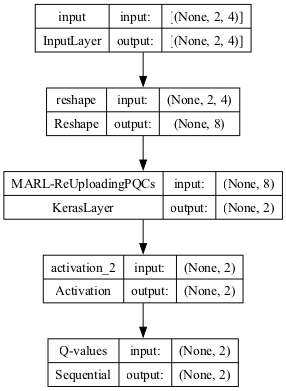

In [23]:
tf.keras.utils.plot_model(model_MARL, show_shapes=True, dpi=70, to_file="model_MARL.png")

(<Figure size 1200x900 with 1 Axes>, <Axes: >)

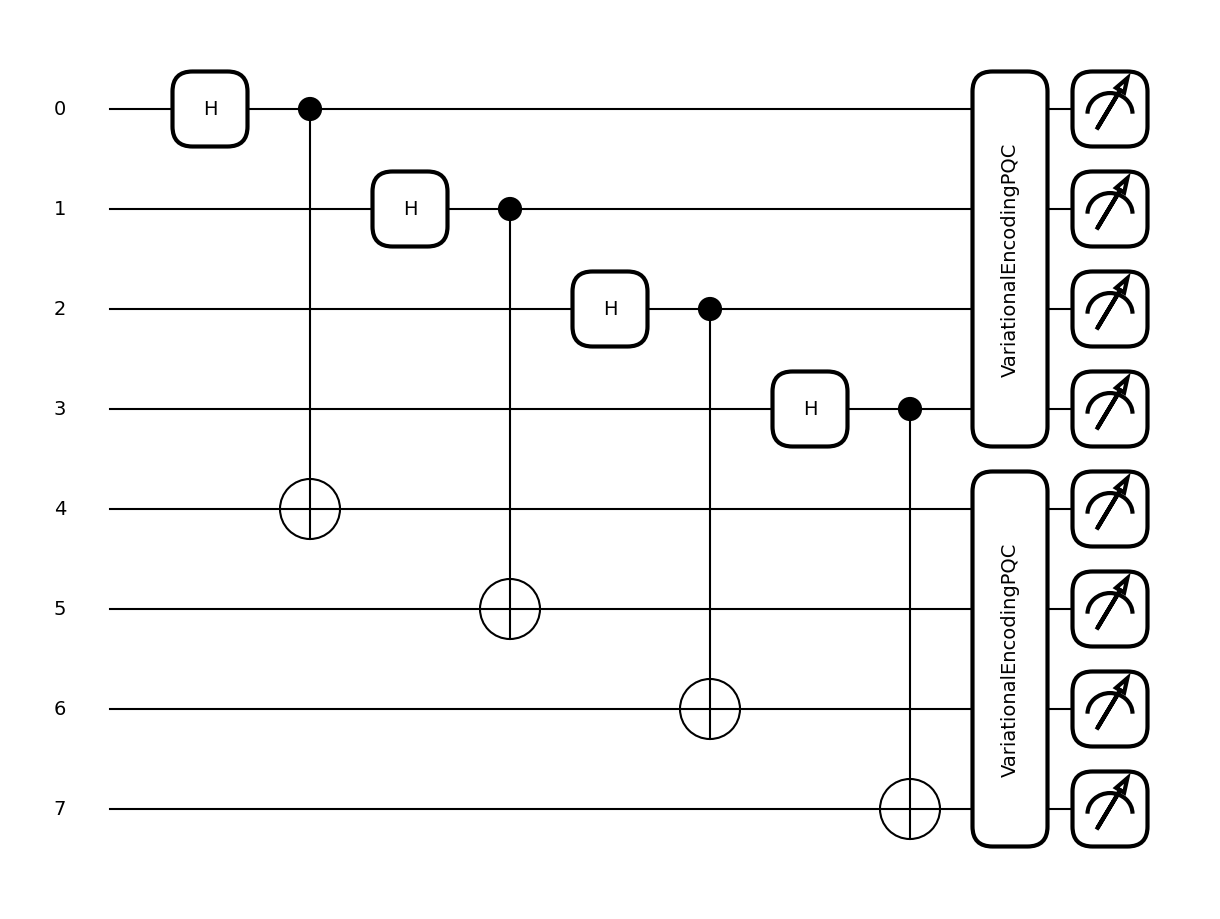

In [24]:
# print(qml.draw(circuit, wire_order=list(range(circuit.n_wires)))(*model.layers[0].weights))
qml.draw_mpl(circuit_MARL, wire_order=list(range(circuit.n_wires)))(*model_MARL.layers[1].weights)

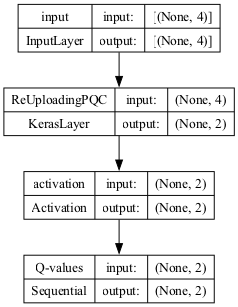

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70, to_file="model_classic.png")

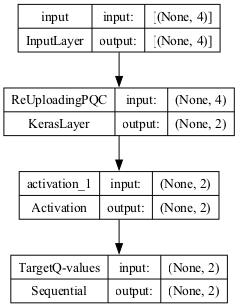

In [26]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70, to_file="model_classic_target.png")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ReUploadingPQC (KerasLayer  (None, 2)                 92        
 )                                                               
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
 Q-values (Sequential)       (None, 2)                 2         
                                                                 
Total params: 94 (376.00 Byte)
Trainable params: 94 (376.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
### Visualize the circuit.
weight_shapes = circuit.weight_shapes
weights = {
    k: np.random.uniform(low=0., high=np.pi, size=s)
    for k, s in weight_shapes.items()
}
# shape_var, shape_enc = circuit.shape
# weights_var = np.random.uniform(low=0., high=np.pi, size=shape_var)
# weights_enc = np.random.uniform(low=0., high=np.pi, size=shape_enc)
print(qml.draw(circuit, wire_order=circuit.wires)(**weights))

0: ─╭VariationalEncodingPQC─┤ ╭<Z@Z>
1: ─├VariationalEncodingPQC─┤ ╰<Z@Z>
2: ─├VariationalEncodingPQC─┤ ╭<Z@Z>
3: ─╰VariationalEncodingPQC─┤ ╰<Z@Z>


In [29]:
def interact_env(state, model, epsilon, n_actions, env):
    # state_shape = state.shape
    # state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
    # state = tf.convert_to_tensor([state]) # Reshape to (1, features) so that batch_size=1.
    state = np.asarray(state).reshape((1, 4)) # Reshape to (1, features) so that batch_size=1.
    
    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else: # Random action.
        action = np.random.choice(n_actions)
    
    next_state, reward, done, _, _ = env.step(action)
    next_state = np.asarray(next_state).reshape(state.shape)
    
    return dict(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done,
    )

In [30]:
### Q-learning update function.

def Q_learning_update(states, actions, rewards, next_states, done, model, model_target, gamma, n_actions, optimizer_w_tups):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)

    # Compute target Q-values and masks on sampled actions.
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    
    masks = tf.one_hot(actions, n_actions)
    
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
        
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in optimizer_w_tups:
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [31]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

optimizer_w_tups = zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out])

In [32]:
### Main training loop

env = gym.make('CartPole-v1')

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    
    while True:
        # Interact with environment.
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Preserve interaction in the replay memory.
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            
            Q_learning_update(
                states=np.asarray([x['state'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
                done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                optimizer_w_tups=optimizer_w_tups,
            )
        
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        if interaction['done']:
            break
        
    # Decay epsilon.
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    
    if (episode+1) % 10 == 0:
        avg_rewards = np.mean(episode_reward_history[-10:])
        print("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
        if avg_rewards >= 500.0:
            break

Episode 10/2000, average last 10 rewards 24.9
Episode 20/2000, average last 10 rewards 19.8
Episode 30/2000, average last 10 rewards 18.7
Episode 40/2000, average last 10 rewards 14.2
Episode 50/2000, average last 10 rewards 16.1
Episode 60/2000, average last 10 rewards 18.1
Episode 70/2000, average last 10 rewards 15.3
Episode 80/2000, average last 10 rewards 15.4
Episode 90/2000, average last 10 rewards 12.8
Episode 100/2000, average last 10 rewards 14.1
Episode 110/2000, average last 10 rewards 14.0
Episode 120/2000, average last 10 rewards 13.6
Episode 130/2000, average last 10 rewards 15.5
Episode 140/2000, average last 10 rewards 13.5
Episode 150/2000, average last 10 rewards 13.7
Episode 160/2000, average last 10 rewards 13.2
Episode 170/2000, average last 10 rewards 13.4
Episode 180/2000, average last 10 rewards 13.1
Episode 190/2000, average last 10 rewards 13.2
Episode 200/2000, average last 10 rewards 13.6
Episode 210/2000, average last 10 rewards 13.6
Episode 220/2000, aver

KeyboardInterrupt: 

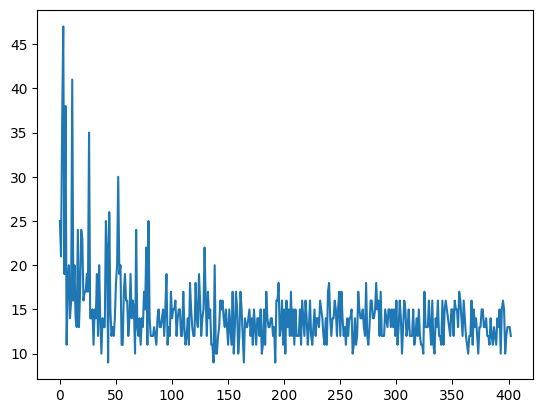

In [33]:
plt.plot(episode_reward_history)

In [40]:
env = gym.make('CartPole-v1')
epsilon = 0

state, _ = env.reset()
trajectory = []
for t in range(100):
    traj = interact_env(state, model, epsilon, n_actions, env)
    trajectory.append(traj)
    if traj['done']:
        break

trajectory

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[{'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00623899, -0.18428296,  0.00549074,  0.29789397]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00255333, -0.37948275,  0.01144862,  0.5923035 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.00503632, -0.57476306,  0.02329469,  0.8885706 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.01653158, -0.7701933 ,  0.0410661 ,  1.1884844 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.0054206

In [44]:
def render_episode_as_gif_frames(env_name, actor, max_steps):
    env = gym.make(env_name, render_mode='rgb_array')
    
    state, _ = env.reset()
    
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    
    for i in range(1, max_steps+1):
        state = tf.expand_dims(state, 0)
        action_probs = actor(state)
        action = np.argmax(np.squeeze(action_probs))
        
        state, reward, done, _, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        
        screen = env.render()
        images.append(Image.fromarray(screen))
        
        if done:
            break

    return images

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )
    
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


rendering 10 frames to GIF ./images/gym_CartPole.gif


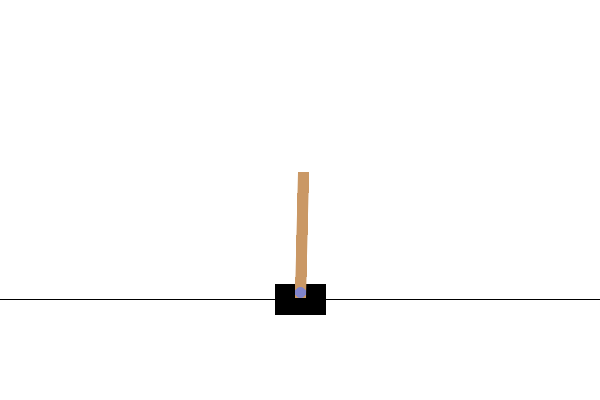

In [45]:
gif_path = './images/gym_CartPole.gif'
frames = render_episode_as_gif_frames('CartPole-v1', model, 100)
print(f"rendering {len(frames)} frames to GIF {gif_path}")
save_frames_as_gif(frames, gif_path)
display_gif(gif_path)